In [1]:
# for interact feature
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# data science packages
from datascience import *
import numpy as np
import re
from pandas import *


# direct plots to appear within the cell, and set their style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# read in the covid data
covid = Table.read_table("/home/jupyter-djf47/us_states_covid19_daily.csv")
covid.show(5)

date,state,positive,negative,pending,hospitalized,death,total,dateChecked,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
20200325,AK,42,1649,nan,1,1,1691,2020-03-25T20:00:00Z,1691,1,1,663,6,669
20200325,AL,283,2529,nan,nan,0,2812,2020-03-25T20:00:00Z,2812,0,0,423,68,491
20200325,AR,280,1437,0,22,2,1717,2020-03-25T20:00:00Z,1717,2,0,490,62,552
20200325,AS,0,nan,nan,nan,0,0,2020-03-25T20:00:00Z,0,0,0,0,0,0
20200325,AZ,450,323,53,8,6,826,2020-03-25T20:00:00Z,773,1,0,10,93,103


In [3]:
# converts date format in the covid table to just a number (since all dates are in March)

def convertDate(date):
    str_date = str(date)
    day = str_date[6:] # since first 6 digits are the year, 2020, and the month, 03
    return int(day)

# Apply this function to the covid table date column

covid = covid.with_column('date', covid.apply(convertDate, 0))

In [4]:
# the covid table filtered to CA

CA_covid = covid.where(1, 'CA')
CA_covid.show(5)

date,state,positive,negative,pending,hospitalized,death,total,dateChecked,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
25,CA,2102,13452,12100,nan,40,27654,2020-03-25T20:00:00Z,15554,0,0,0,0,0
24,CA,2102,13452,12100,nan,40,27654,2020-03-24T20:00:00Z,15554,13,0,885,369,1254
23,CA,1733,12567,12100,nan,27,26400,2020-03-23T20:00:00Z,14300,0,0,1263,197,1460
22,CA,1536,11304,nan,nan,27,12840,2020-03-22T20:00:00Z,12840,3,0,55,257,312
21,CA,1279,11249,nan,nan,24,12528,2020-03-21T20:00:00Z,12528,4,0,825,216,1041


In [5]:
# creates a list of list of states, for use in the interact feature below

def createListStates(states):
    result = []
    for i in states:
        result.append([str(i)])
    return result

listofstates = createListStates(covid.group(1).column(0))
listofstates

[['AK'],
 ['AL'],
 ['AR'],
 ['AS'],
 ['AZ'],
 ['CA'],
 ['CO'],
 ['CT'],
 ['DC'],
 ['DE'],
 ['FL'],
 ['GA'],
 ['GU'],
 ['HI'],
 ['IA'],
 ['ID'],
 ['IL'],
 ['IN'],
 ['KS'],
 ['KY'],
 ['LA'],
 ['MA'],
 ['MD'],
 ['ME'],
 ['MI'],
 ['MN'],
 ['MO'],
 ['MP'],
 ['MS'],
 ['MT'],
 ['NC'],
 ['ND'],
 ['NE'],
 ['NH'],
 ['NJ'],
 ['NM'],
 ['NV'],
 ['NY'],
 ['OH'],
 ['OK'],
 ['OR'],
 ['PA'],
 ['PR'],
 ['RI'],
 ['SC'],
 ['SD'],
 ['TN'],
 ['TX'],
 ['UT'],
 ['VA'],
 ['VI'],
 ['VT'],
 ['WA'],
 ['WI'],
 ['WV'],
 ['WY']]

In [6]:
# returns an array of the days that the number of cases were double the number of cases of the previous double day, starting with day 1

def doubled_days(date, cases): #takes date and positive cases array in ascending order
    current = cases[0]
    days_doubled = []
    for i in np.arange(0,len(date)):
        if (cases[i] >= (2*current)):
            current = cases[i]
            days_doubled.append(date[i]-(date[0]-1)) #subtract because the 1st day of data is not March 1st
    return days_doubled

CA_covid_ascending = CA_covid.sort(2, descending = False)
dates_array = CA_covid_ascending.column(0)
cases_array = CA_covid_ascending.column(2)
dates_array.sort()
cases_array.sort()

days_doubled = doubled_days(dates_array, cases_array) 
days_doubled # for CA

[6, 11, 15, 18]

#### Explanation of this result

This array, [6, 11, 15, 18] means that on the 6th, 11th, etc. day of recording data, the number of cases was double what it was the last time it doubled. For example (this is re-stated at the end of this file), on day 1 (March 4th) there were 53 cases. This first doubled (to 114) on the 6th day of recording data (March 9th). This then doubled again on the 11th day (to 252 on March 14th), etc. Take a look at the table below for confirmation of this.

In [7]:
CA_covid.sort(2).show(11)

date,state,positive,negative,pending,hospitalized,death,total,dateChecked,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
5,CA,53,462,nan,nan,nan,515,2020-03-05T21:00:00Z,515,0,0,0,0,0
4,CA,53,462,nan,nan,nan,515,2020-03-04T21:00:00Z,515,nan,nan,nan,nan,nan
6,CA,60,462,nan,nan,nan,522,2020-03-06T21:00:00Z,522,0,0,0,7,7
7,CA,69,462,nan,nan,nan,531,2020-03-07T21:00:00Z,531,0,0,0,9,9
8,CA,88,462,nan,nan,nan,550,2020-03-08T20:00:00Z,550,0,0,0,19,19
9,CA,114,690,nan,nan,nan,804,2020-03-09T20:00:00Z,804,0,0,228,26,254
10,CA,133,690,nan,nan,nan,823,2020-03-10T20:00:00Z,823,0,0,0,19,19
11,CA,157,916,nan,nan,nan,1073,2020-03-11T20:00:00Z,1073,0,0,226,24,250
13,CA,202,916,nan,nan,4,1118,2020-03-13T20:00:00Z,1118,0,0,0,0,0
12,CA,202,916,nan,nan,4,1118,2020-03-12T20:00:00Z,1118,4,0,0,45,45


In [8]:
# calculates the average duration between doublings using the array generated in the function above

def averageDuration(array):
    result = 0
    for i in np.arange(0, len(array)-1):
        result = result + (array[i+1] - array[i])
    return result/(len(array)-1)  

averageDuration(days_doubled)

4.0

Analysis for CA :

Days that cases doubled, starting from the first recorded date ( March 4 ), which had 53.0 cases: [6, 11, 15, 18] , for a total of 4 doublings since March 4th.

The last time it doubled was from March 18 to March 21 . The average number of days between doublings is 4.0

The current number of positive cases in CA (as of March 25th) is 2102.0 , which is 456.0 cases away from doubling again. The average reported above suggests that the number of positive cases should double again in 0.0 days (considering today is March 25th).

Note that a 0 means that it should have doubled again today (March 25th), but has not.

Analysis for IL :

Days that cases doubled, starting from the first recorded date ( March 4 ), which had 4.0 cases: [7, 11, 13, 15, 17, 20] , for a total of 6 doublings since March 4th.

The last time it doubled was from March 20 to March 23 . The average number of days between doublings is 2.6

The current number of positive cases in IL (as of March 25th) is 1

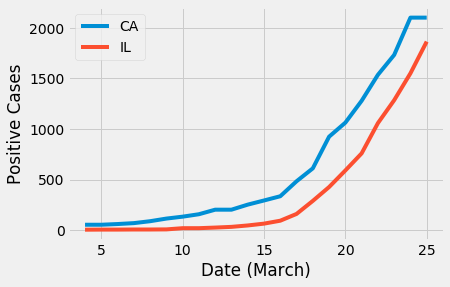

In [9]:
# returns paragraph of analysis for given state(s) including overlayed plot for each of the states given

def covidAnalysis(state):
    
    for i in state:
        
        state_covid = covid.where(1, i)
    
        # check if given state is valid or not
        all_states = covid.group(1).column(0)
        if i not in all_states:
            print('Invalid state')
            return
    
        # plot of positive cases over time
        plt.plot(state_covid.column(0), state_covid.column(2), label = i)
        plt.xlabel('Date (March)')
        plt.ylabel('Positive Cases')
        plt.legend()
    
        state_covid_ascending = state_covid.sort(1, descending = False)
        dates_array = state_covid_ascending.column(0)
        cases_array = state_covid_ascending.column(2)
        dates_array.sort()
        cases_array.sort()
    
        days_doubled = doubled_days(dates_array, cases_array)
        
        print('Analysis for', i,':')
        print('')
        
        print('Days that cases doubled, starting from the first recorded date ( March', dates_array[0],'), which had',state_covid_ascending.column(2)[0], 
              'cases:', days_doubled,', for a total of', len(days_doubled), 
              'doublings since March 4th.')
        print('')
        print('The last time it doubled was from March', days_doubled[len(days_doubled)-2]+(dates_array[0]-1), 'to March',days_doubled[len(days_doubled)-1]+(dates_array[0]-1),
              '. The average number of days between doublings is', round(averageDuration(days_doubled), 3))
        print('')
        print('The current number of positive cases in', i, '(as of March 25th) is', state_covid.column(2)[0], 
              ', which is', 2*(state_covid_ascending.where(0, (days_doubled[len(days_doubled)-1])+(dates_array[0]-1)).column(2)[0])-state_covid.column(2)[0], 
              'cases away from doubling again. The average reported above suggests that the number of positive cases should double again in',
             round(((days_doubled[len(days_doubled)-1]+3)+averageDuration(days_doubled)) - 25), 'days (considering today is March 25th).') 
    
        print('')
        if ((round(((days_doubled[len(days_doubled)-1]+3)+averageDuration(days_doubled)) - 25)) < 0):
            print('Note that a negative number of days means it should have doubled already, but has not.')
            print('')
        if ((round(((days_doubled[len(days_doubled)-1]+3)+averageDuration(days_doubled)) - 25)) == 0): 
            print('Note that a 0 means that it should have doubled again today (March 25th), but has not.')
            print('')
            
covidAnalysis(['CA', 'IL'])

In [10]:
def f(a,t,k): #exponential function, taking arguments a (initial value), t (time), k (growth rate)
    return round(a*np.e**(k*t))

# if amonut doubles every 4 days, growth rate is ln(2)/4
print(f(53, 0, np.log(3)/4))
print(f(53, 4, np.log(2)/4))
print(f(53, 8, np.log(2)/4))

53.0
106.0
212.0


In [12]:
# calculates the number of cases in a given state if the current rate of doubling were to continue for ndays days

def continueDouble(state, ndays):
    
    for i in state:
        
        state_covid = covid.where(1, i)
    
        all_states = covid.group(1).column(0)
        if i not in all_states:
            print('Invalid state')
            return
    
        state_covid_ascending = state_covid.sort(1, descending = False)
        dates_array = state_covid_ascending.column(0)
        cases_array = state_covid_ascending.column(2)
        
        continuation_table = Table().with_columns('Date (March)', dates_array, 'Positive Cases', cases_array) #for later use below
        
        #sort the continuation table for use in doubled_days function
        continuation_table = continuation_table.sort(0, descending = False)
        # sort the dates and cases array for use in calculating the current number of cases and current date
        dates_array.sort()
        cases_array.sort()
    
        days_doubled = doubled_days(continuation_table.column(0), continuation_table.column(1))
        average_duration = averageDuration(days_doubled)
        
        growth_rate = np.log(2)/average_duration
        
        # add row to continuation table for each day after the last recorded date where data was recorded
        # adds rows based on exponential model with the growth rate calculated using the average duration between doublings
        for j in np.arange(0, ndays):
            continuation_table = continuation_table.with_row([(dates_array[len(dates_array)-1]+j+1), (f(cases_array[len(cases_array)-1],j,growth_rate))])
            
        # plot the projection given the current trend of doubling every x days continues for ndays days
        plt.plot(continuation_table.column(0), continuation_table.column(1))
        
        print('There are currently', cases_array[len(cases_array)-1], 'cases in', i)
        print('If this rate ( doubling every', round(average_duration, 3), 'days ) continues for', ndays, 'days, then there will be',f(cases_array[len(cases_array)-1],ndays,growth_rate), 'cases')

There are currently 2102.0 cases in CA
If this rate ( doubling every 4.0 days ) continues for 20 days, then there will be 67264.0 cases


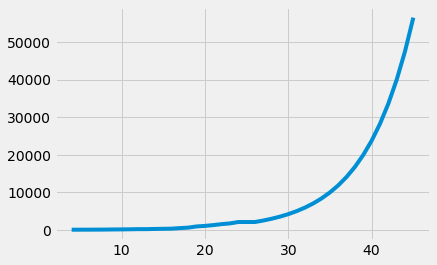

In [13]:
# example: if the current rate of doubling in CA so far continues for 20 days, there will be this many cases
continueDouble(['CA'], 20)
# we can see that the exponential model takes over after the 25th, which is the last day of recorded data

In [14]:
# interact feature: choose a state from the dropdown meny and adjust the slider for the number of days
# ndays ranges from 0 days to 1 month (30 days)
interact(continueDouble, state = listofstates, ndays = widgets.IntSlider(min=0, max=30, step=1, value=5))
# this does not show up on the HTML file, but I have attached a picture of the module to the email sent

interactive(children=(Dropdown(description='state', options=(['AK'], ['AL'], ['AR'], ['AS'], ['AZ'], ['CA'], […

<function __main__.continueDouble(state, ndays)>

## Overall Analysis for CA

The number of positive cases in California has doubled 4 times since the first set of data was recorded on March 4th (53 cases). On March 25th, the number of cases is close to doubling again since the last doubling event on March 21st. This analysis may be flawed because there is a very limited data set thus far, but across all states the average duration between doublings seems to be in a similar range: about 2-4. 

It seems that the number of positive cases in CA is doubling every 3-5 days (average of 4 days). It also seems that it is doubling more rapidly as time goes on, with there being 5 days between the first doubling (March 4th-March 9th), 5 between the second (March 9th-March 14th), 4 between the third (March 14th-March 18th), and 3 between the fourth (March 18th-March 21st). It is not immediately clear if this negative trend in the number of days between doublings is just a coincidence due to limited data, or if it means that the number of positive cases is more quickly accelerating. I suspect that although there is limited data here, it is in fact accelerating (so some of both). However, note that the last time it doubled was 5 days ago already, and it has not doubled yet. 

See below for detailed explanation of the 4 doubling events:

It first "doubled" from 53 to 114 on March 9th (the 6th day of recorded data). Then, it doubled again up to 252 on March 14th (11th day). Then, doubled again to 611 on March 18th (15th day), and lastly up to 1279 on March 21st (18th day). It is currently March 26th and the number of cases is 2102. The average of 4 days between doublings suggests that this number should hit 2558 (double the amount when it last doubled on March 21st) very soon.

### Modifications

Note that this method of analysis can very easily be modified to be applied to visualize many different aspects of the spread of COVID-19. For example, it would be simple to plot the percentage of the population that is infected rather than just the total amount of cases, which would give a better idea of how serious this situation is in different states. Also, the raw data used includes information about deaths, negative tests, people hospitalized, etc, so we could also analyze these numbers in the same way as instead of using positive cases. I am also interested in finding data about the number of available tests to see if the increase in positive cases is in large part due to there being many more tests available, and these "new" cases are not actually new at all (they were just undetected before). However, I was not able to find this data anywhere. 